# Analyzing Cannabinoid Edibles Patent Document Dataset with Non-negative Matrix Factorization 

This project uses unsupervised learning to discover patterns in a dataset of patent titles and other patent metadata information for patent documents related to Cannabinoid edibles.
                                                                                                                                
Patent offices around the world issue millions of patents every year. It is difficult for companies with large patent portfolios to understand and manage their patent assets for a specific technology area. Machine learning can help automate tasks that have previously been entirely handled by human beings. This problem is an attempt to demonstrate the ability of machine learning to classify patents as belonging in a particular category of asset, in this case whether a patent is related to Cannaboid Edible technology or not. For this particular exercise, we are relying exclusively on patent metadata information (title, publication date, serial number, family id). While more accurate results would be achievable using the full text and drawings of a full patent document, that would require significantly more processing power. As shown below in the results section, the accuracy, precision, recall, and F1 scores are reasonable even without using the full text.  Better results would be achievable with additional metadata information (claims, abstract) and/or full text.  

### Matrix Factorization
Matrix factorization is one of the most popular unsupervised learning techniques for analyzing document textual information when handling a corpus of documents.  There are several different MF methods including Singular Value Decomposition, Non-negative Matrix Factorization (NMF), and approximation methods.

I chose NMF using sklearn.decomposition.NMF.  I analyze the patent test titles and other metadata information using Non-negative Matrix Factorization, comparing Frobenius NMF and KL-Divergence loss.  For KL-divergence loss, I also vary the Number of Components hyperparameter to see the impact on accuracy and reconstruction error.

NMF is used to breadown a large dataset into smaller meaningful parts.  For a matrix A of dimensions mxn where element is >=0, NMF factorizes it into two matrixes W and H with dimensions mxk and kxn, where both matrices only contain non-negative elements.
A is the original matrix
W feature matrix (basis components)
H coeffienct matrix (weights associated with W)

NMF helps identify hidden patterns in data.   Each data point is represented as a combination of features found in W.

#### Supervised Learning Comparison 
For comparison purposes, I also perform a supervised learning logistic regression on the patent titles classification analysis on the patent titles to determine whether the patents refer to cannabinoid edible technology or not. This is an NLP task requiring understanding of cannabinoid edible terminology, patent language, and distinguishing between cannabinoid edibles and other related technologies.

This sort of machine learning task is easily translatable to other technologies beyond Cannabinoid Edibles to enable companies to analyze their IP portfolios for specific areas of investment.

The data set includes patent documents with metadata including patent title, patent family number, patent serial number, publication date, and whether the patent document is classified as being related to Cannabinoid Edibles.

### Cannabinoid Edible Patent Document Dataset Structure:

Column 1: Classification (negative/positive for qubit related) (col. 1 generated by human beings as described in Harris article below)

Column 2: DocDB Family ID

Column 3: Serial No.

Column 4: Title of patent application (main text for classification)

Column 5: Publication date

The data file description: "The positive collection discuss edible items, which can include lozenges, beverages, or powders containing a cannabinoid
substance that can be used directly by oral absorption, or by formulating into a foodstuff for oral consumption. Cannabinoid substances include 
products from Cannabis sativa, ruderalis, or indica as well as products coming from the processing of hemp including hemp seeds, fibers, or oils."

"All of the records in the negative collection mention an edible item of one sort or another, and specifically a foodstuff."

### References

Dataset located at: https://github.com/swh/classification-gold-standard

See this article for the background behind the creation of the dataset. Steve Harris, Anthony Trippe, David Challis, and Nigel Swycher, "Construction and evaluation of gold standards for patent classification—A case study on quantum computing", World Patent Information, Vol 61, June, 2020.
https://www.sciencedirect.com/science/article/pii/S0172219019300791

https://medium.com/betacom/bow-tf-idf-in-python-for-unsupervised-learning-task-88f3b63ccd6d

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

https://www.ml4patents.com/

"Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation" https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

Le Thi Khanh Hien, Nicolas Gillis, "Algorithms for Nonnegative Matrix Factorization with the Kullback-Leibler Divergence,"
https://arxiv.org/abs/2010.01935

FreeCodeCamp on TF-IDF for text processing https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/

Medium blog post on TF-IDF for text processing https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424

This Jupyter Notebook python code was written using Anaconda Navigator and is located at: https://github.com/tomplunkett/Data-Science/tree/main/Patents%20Unsupervised%20Learning

In [2]:
# EDA NMF analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns

# Global variables to store data and models
df = None
train_df = None
test_df = None
vectorizer = None
tfidf_matrix = None
class_col = None
title_col = None

In [3]:
def load_and_preprocess_data(file_path):
    """Load and preprocess patent data"""
    global df, train_df, test_df, class_col, title_col
    
    print(f"Loading data from: {file_path}")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', encoding='utf-8', 
                     engine='python', quoting=3)
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('.', '')
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Auto-detect key columns
    detect_columns()
    
    # Create binary target
    create_binary_target()
    
    # Clean data
    clean_data()
    
    # Split data
    split_data()
    
    print(f"Training set: {len(train_df)}, Test set: {len(test_df)}")

def detect_columns():
    """Automatically detect classification and title columns"""
    global class_col, title_col
    
    # Find classification column
    class_col = None
    for col in ['classification', 'class', 'label', 'target']:
        if col in df.columns:
            class_col = col
            break
    
    if class_col is None:
        # Check first column for classification
        first_col = df.columns[0]
        if len(df[first_col].unique()) <= 10:
            class_col = first_col
    
    # Find title column
    title_col = None
    for col in df.columns:
        if 'title' in col.lower():
            title_col = col
            break
    
    if title_col is None and len(df.columns) >= 4:
        title_col = df.columns[3]  # Assume 4th column is title
        
    print(f"Using '{class_col}' for classification")
    print(f"Using '{title_col}' for text analysis")

def create_binary_target():
    """Create binary target variable"""
    global df
    
    if class_col is None:
        raise ValueError("Could not identify classification column")
        
    unique_vals = df[class_col].unique()
    print(f"Unique classifications: {unique_vals}")
    
    # Standard positive/negative mapping
    if 'positive' in unique_vals and 'negative' in unique_vals:
        df['target'] = df[class_col].map({'positive': 1, 'negative': 0})
    else:
        # Map first to 0, second to 1
        mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
        df['target'] = df[class_col].map(mapping)
        print(f"Applied mapping: {mapping}")

def clean_data():
    """Clean data by removing missing values"""
    global df
    
    print(f"Shape before cleaning: {df.shape}")
    
    # Remove rows with missing title or target
    df = df.dropna(subset=[title_col, 'target'])
    
    # Remove duplicates - keep document with earliest publication date for each family
    docdb_cols = [col for col in df.columns if 'docdb' in col.lower()]
    pub_date_cols = [col for col in df.columns if 'publication' in col.lower() and 'date' in col.lower()]
    
    if docdb_cols and pub_date_cols:
        docdb_col = docdb_cols[0]
        pub_date_col = pub_date_cols[0]
        
        print(f"Using '{docdb_col}' for family grouping and '{pub_date_col}' for date sorting")
        
        before_dedup = len(df)
        
        # Convert publication date to datetime for proper sorting
        try:
            # Try common date formats
            df[pub_date_col] = pd.to_datetime(df[pub_date_col], errors='coerce')
            
            # Sort by DocDB family and publication date, then keep first (earliest) for each family
            df = df.sort_values([docdb_col, pub_date_col])
            df = df.drop_duplicates(subset=[docdb_col], keep='first')
            
            print(f"Removed {before_dedup - len(df)} duplicates (kept earliest publication date per family)")
            
        except Exception as e:
            print(f"Warning: Could not parse publication dates ({e})")
            print("Falling back to keeping first occurrence per family")
            df = df.drop_duplicates(subset=[docdb_col], keep='first')
            print(f"Removed {before_dedup - len(df)} duplicates")
            
    elif docdb_cols:
        # If no publication date column found, fall back to original behavior
        before_dedup = len(df)
        df = df.drop_duplicates(subset=[docdb_cols[0]], keep='first')
        print(f"No publication date column found. Removed {before_dedup - len(df)} duplicates (kept first occurrence)")
        
    print(f"Shape after cleaning: {df.shape}")

def split_data():
    """Split data into train/test sets"""
    global train_df, test_df
    
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, 
        stratify=df['target']
    )
    
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)


# Load and preprocess
load_and_preprocess_data("data/patent_unsupervised_learning/cannabinoid-edibles.tsv")


Loading data from: data/patent_unsupervised_learning/cannabinoid-edibles.tsv
Dataset shape: (10794, 5)
Columns: ['class', 'docdb_family_id', 'serial_no', 'title', 'publication_date']
Using 'class' for classification
Using 'title' for text analysis
Unique classifications: ['negative' 'positive']
Shape before cleaning: (10794, 6)
Using 'docdb_family_id' for family grouping and 'publication_date' for date sorting
Removed 9173 duplicates (kept earliest publication date per family)
Shape after cleaning: (1600, 6)
Training set: 1280, Test set: 320


## Extracting Word Features and Exploratory Data Analysis (EDA) Plan

#### Data Loading and Initial Inspection
After loading the dataset into Jupyter notebooks on Anaconda, then perform initial inspections on the dataframes. After data cleansing, tbe dataset should be relatively small (1600 documents, with 80% in training and 20% in test).  

### TF-IDF Feature Extraction
The next step is TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert the text data into numerical features. TF-IDF works by calculating how frequently a word appears in a document (TF), wownweighting words that appear across many documents (IDF), and producing a matrix where each row represents a document and each column represents a term.

This captures the importance of words within documents while accounting for their commonality across the corpus.  It reduces the impact of very frequent but less informative words.  It creates features that can be directly used for unsupervised learning techniques
  
#### Exploratory Data Analysis
Examine TF-IDF weights vs. words to understand feature importance, showing six graphs.  Top words 1-25, 26-50, and 51-75 for both positive and negative classes. 

#### Analysis Plan
- Use the training data for EDA to understand potential patterns
- Apply matrix factorization techniques to the TF-IDF matrix
- Determine the optimal number of categories by examining the distribution in the training data
- Evaluate the coherence of the resulting clusters against the known categories in the training data

#### Using Supervised Learning Logistic Regression as a comparison
I will also use supervised learning logisitic regression as a comparison to see how supervised learning performs on the same dataset.  


Class Distribution:


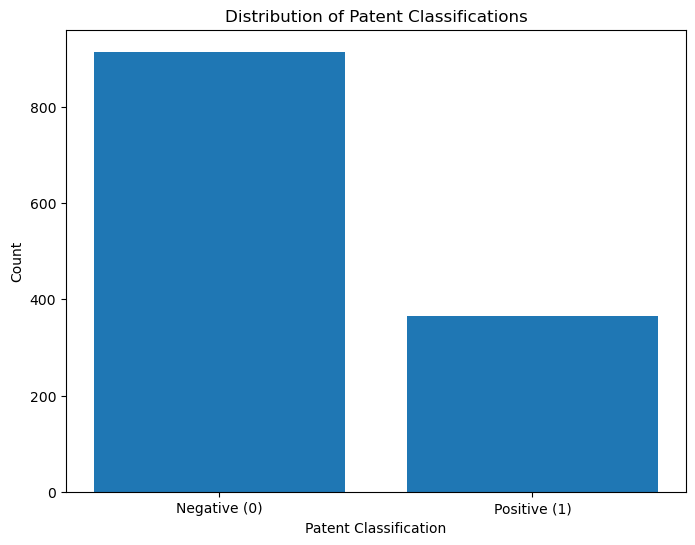

In [5]:
def plot_class_distribution():
    """Plot distribution of classes"""
    plt.figure(figsize=(8, 6))
    counts = train_df['target'].value_counts()
    plt.bar(['Negative (0)', 'Positive (1)'], [counts[0], counts[1]])
    plt.xlabel("Patent Classification")
    plt.ylabel("Count")
    plt.title("Distribution of Patent Classifications")
    plt.show()

# Visualize class distribution
print("\nClass Distribution:")
plot_class_distribution()

#### Data Cleansing reduced data set size
Data cleansing reduced the data set of over 10,000 patent documents (many documents with duplicative data) to 1600 unique documents (using the family ID to remove 2nd and subsequent documents that belong to the same "patent family."  The 1600 unique documents were then sub-divided 80-20 into 1280 training documents and 320 test documents.  As shown in the bar chart above, there over 800 negative documents and approximately 400 documents that were classified as positive for Cannabinoid Edibles.  

# Cannabinoid Patent Title Vocabulary Feature Extraction with TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a powerful statistical method for extracting features from text data. It creates a numerical representation of documents that balances the importance of words based on their frequency in individual documents and their rarity across the entire corpus.

## How TF-IDF Works

TF-IDF consists of two components that are multiplied together:

1. **Term Frequency (TF)**: Measures how frequently a term appears in a document
   - Formula: TF(t,d) = (Number of times term t appears in document d) / (Total number of terms in document d)

2. **Inverse Document Frequency (IDF)**: Measures how important a term is by considering its rarity across all documents
   - Formula: IDF(t) = log(Total number of documents / Number of documents containing term t)

3. **TF-IDF Score**: TF(t,d) × IDF(t)

## Why TF-IDF is Effective

The underlying principle of TF-IDF is that:
- Words that appear frequently in a specific document but rarely in other documents are likely to be highly relevant for categorizing that document
- Common words that appear across many documents (like "the", "and", "is") receive lower weights
- The more frequently a rare term appears in a document, the stronger its signal for categorization

## Implementation in scikit-learn

scikit-learn handles the normalization and calculation of TF-IDF matrices efficiently:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,           # Minimum document frequency (ignore terms that appear in fewer than 5 documents)
    max_df=0.8,         # Maximum document frequency (ignore terms that appear in more than 80% of documents)
    sublinear_tf=True,  # Apply sublinear tf scaling (replace tf with 1 + log(tf))
    use_idf=True,       # Enable IDF weighting
    ngram_range=(1, 1)  # Only consider single words (unigrams)
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_documents)

# Transform the test data using the same vocabulary
X_test_tfidf = tfidf_vectorizer.transform(test_documents)

## Output and Dimensionality

The resulting TF-IDF matrix has:
- Rows representing documents (patent documents in our case)
- Columns representing unique terms in the vocabulary
- Values representing the TF-IDF weights

This creates a sparse matrix with dimensions (number_of_documents × number_of_unique_terms), which can be directly used as input features for machine learning models like logistic regression, SVM, or neural networks.

The TF-IDF representation effectively captures the semantic importance of words in documents, making it particularly useful for text classification tasks like patent title categorization.

"How to Process Textual Data Using TF-IDF in Python", FreeCodeCamp 
https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/
"Creating a TF-IDF in Python", Medium
https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424


Text Feature Analysis Comparing TF-IDF for Positive and Negative classes for Top 75 words:


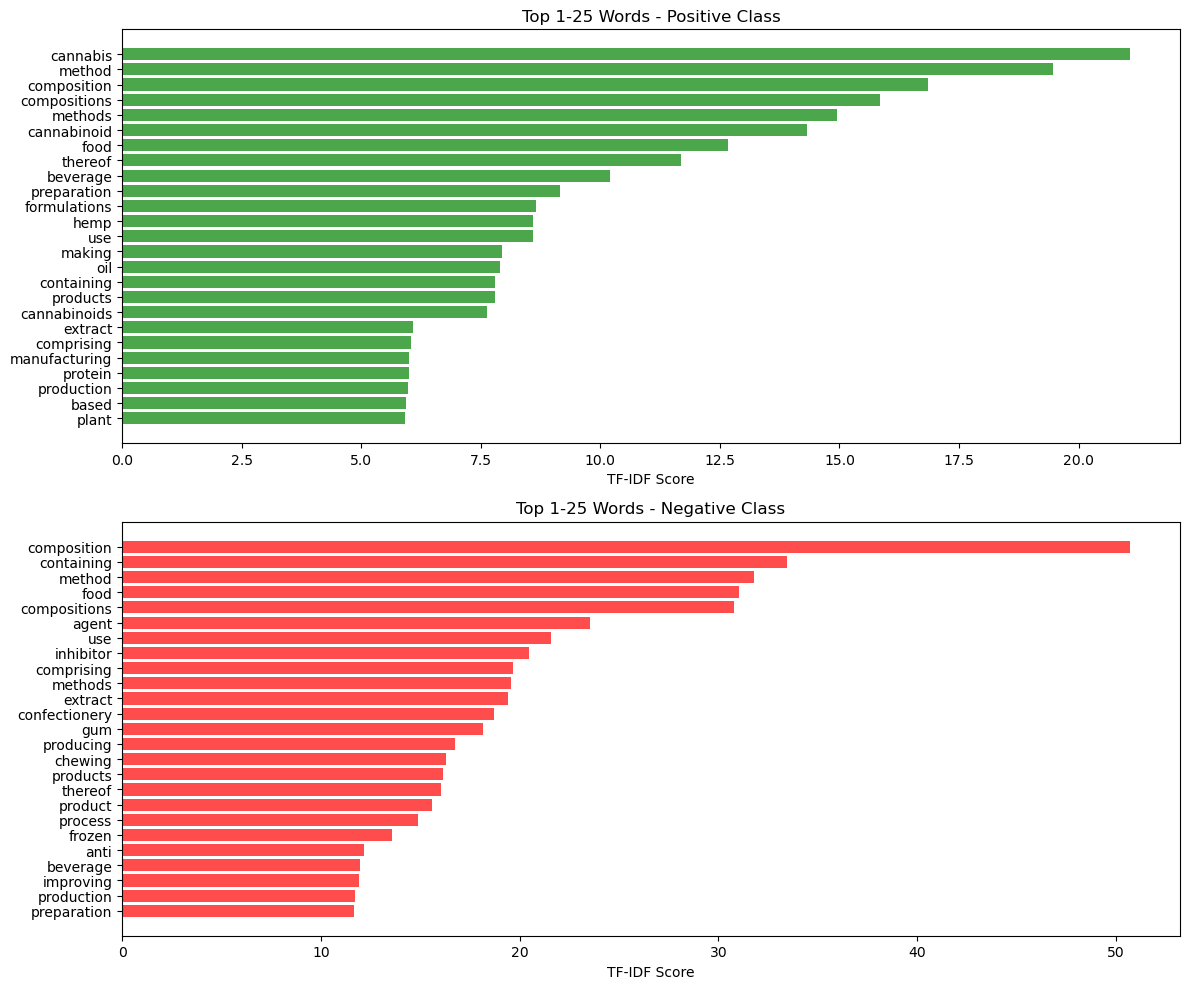

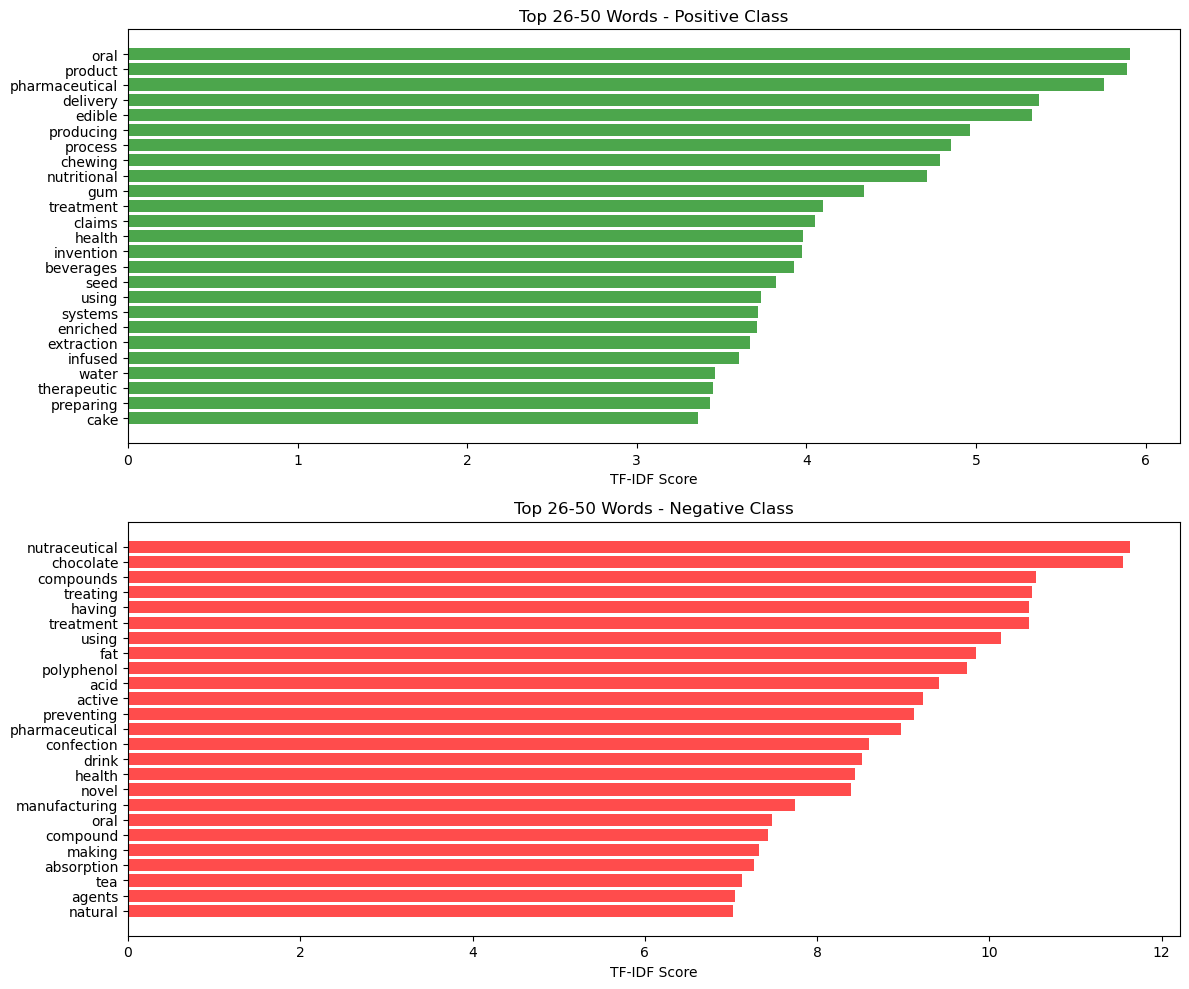

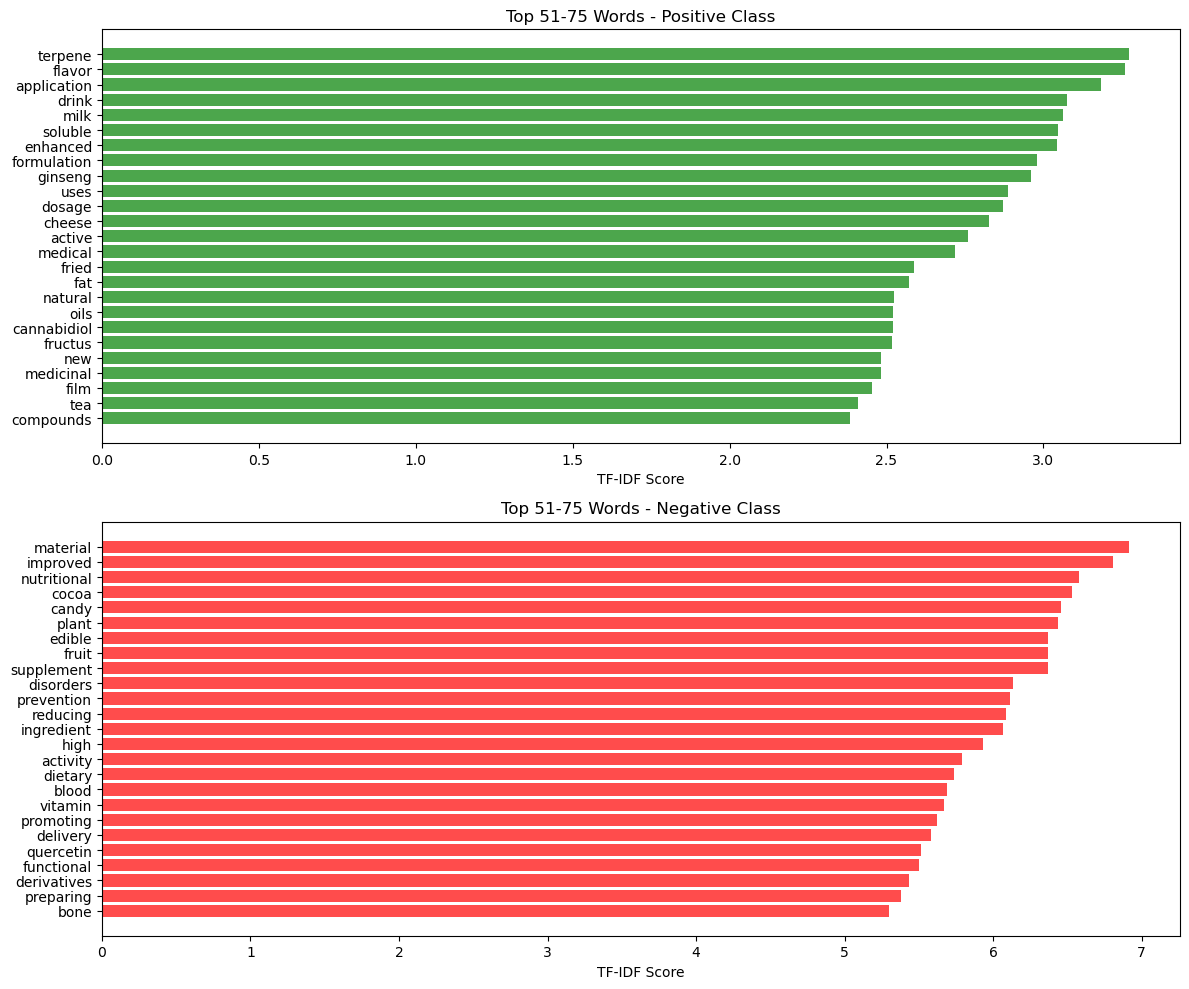

In [8]:
def analyze_text_features(n_words=25):
    """Analyze text features by class with extended word ranges"""
    positive_docs = train_df[train_df['target'] == 1][title_col].tolist()
    negative_docs = train_df[train_df['target'] == 0][title_col].tolist()
    
    # Create separate vectorizers for each class
    pos_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
    neg_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
    
    pos_tfidf = pos_vectorizer.fit_transform(positive_docs)
    neg_tfidf = neg_vectorizer.fit_transform(negative_docs)
    
    # Get top words for each class
    pos_scores = np.array(pos_tfidf.sum(axis=0)).flatten()
    neg_scores = np.array(neg_tfidf.sum(axis=0)).flatten()
    
    pos_words = pos_vectorizer.get_feature_names_out()
    neg_words = neg_vectorizer.get_feature_names_out()
    
    # Get sorted indices for all words
    pos_sorted_idx = np.argsort(pos_scores)[::-1]
    neg_sorted_idx = np.argsort(neg_scores)[::-1]
    
    # Define word ranges
    ranges = [
        (0, 25, "Top 1-25 Words"),
        (25, 50, "Top 26-50 Words"), 
        (50, 75, "Top 51-75 Words")
    ]
    
    for start_idx, end_idx, title_suffix in ranges:
        # Check if we have enough words for this range
        if len(pos_words) <= start_idx or len(neg_words) <= start_idx:
            print(f"Skipping {title_suffix} - not enough words in vocabulary")
            continue
            
        # Adjust end_idx if we don't have enough words
        pos_end = min(end_idx, len(pos_words))
        neg_end = min(end_idx, len(neg_words))
        
        actual_n_pos = pos_end - start_idx
        actual_n_neg = neg_end - start_idx
        
        if actual_n_pos <= 0 or actual_n_neg <= 0:
            continue
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Positive class
        pos_range_idx = pos_sorted_idx[start_idx:pos_end]
        ax1.barh(range(actual_n_pos), pos_scores[pos_range_idx], color='green', alpha=0.7)
        ax1.set_yticks(range(actual_n_pos))
        ax1.set_yticklabels(pos_words[pos_range_idx])
        ax1.set_title(f'{title_suffix} - Positive Class')
        ax1.set_xlabel('TF-IDF Score')
        ax1.invert_yaxis()  # Show highest scores at top
        
        # Negative class
        neg_range_idx = neg_sorted_idx[start_idx:neg_end]
        ax2.barh(range(actual_n_neg), neg_scores[neg_range_idx], color='red', alpha=0.7)
        ax2.set_yticks(range(actual_n_neg))
        ax2.set_yticklabels(neg_words[neg_range_idx])
        ax2.set_title(f'{title_suffix} - Negative Class')
        ax2.set_xlabel('TF-IDF Score')
        ax2.invert_yaxis()  # Show highest scores at top
        
        plt.tight_layout()
        plt.show()

# Text analysis
print("\nText Feature Analysis Comparing TF-IDF for Positive and Negative classes for Top 75 words:")
analyze_text_features()


Word Clouds:


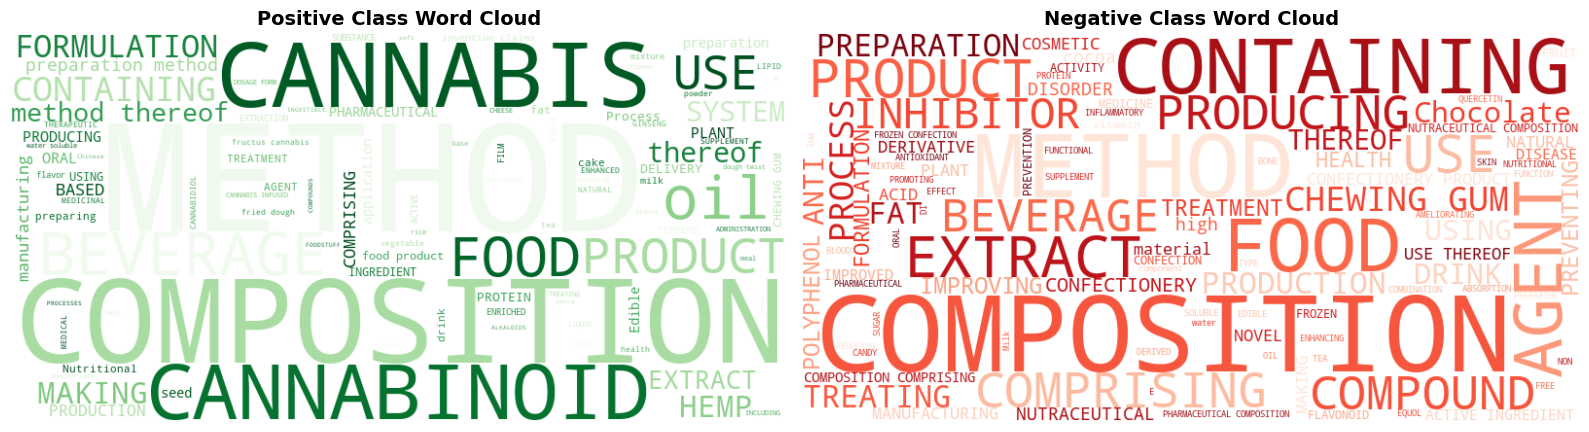

In [9]:
def create_wordclouds():
    """Create word clouds for both classes"""
    positive_text = ' '.join(train_df[train_df['target'] == 1][title_col])
    negative_text = ' '.join(train_df[train_df['target'] == 0][title_col])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Positive class
    pos_wc = WordCloud(width=800, height=400, background_color='white',
                      colormap='Greens', max_words=100).generate(positive_text)
    ax1.imshow(pos_wc, interpolation='bilinear')
    ax1.axis('off')
    ax1.set_title('Positive Class Word Cloud', fontsize=14, fontweight='bold')
    
    # Negative class
    neg_wc = WordCloud(width=800, height=400, background_color='white',
                      colormap='Reds', max_words=100).generate(negative_text)
    ax2.imshow(neg_wc, interpolation='bilinear')
    ax2.axis('off')
    ax2.set_title('Negative Class Word Cloud', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Word clouds
print("\nWord Clouds:")
create_wordclouds()

In [10]:
def create_tfidf_matrix():
    """Create TF-IDF matrix for all documents"""
    global vectorizer, tfidf_matrix
    
    all_titles = pd.concat([
        train_df[title_col], 
        test_df[title_col]
    ]).tolist()
    
    vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(all_titles)
    
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

In [11]:
def run_nmf_analysis(n_components=2):
    """Run NMF analysis with different loss functions"""
    if tfidf_matrix is None:
        create_tfidf_matrix()
        
    results = {}
    
    # Frobenius loss
    nmf_frob = NMF(n_components=n_components, random_state=42, 
                  init='nndsvd', max_iter=1000)
    W_frob = nmf_frob.fit_transform(tfidf_matrix)
    
    # KL divergence loss
    nmf_kl = NMF(n_components=n_components, random_state=42, 
                init='nndsvda', solver='mu', beta_loss='kullback-leibler', 
                max_iter=1000)
    W_kl = nmf_kl.fit_transform(tfidf_matrix)
    
    # Store models for topic exploration
    models = {
        'Frobenius': (nmf_frob, W_frob),
        'KL-Divergence': (nmf_kl, W_kl)
    }
    
    # Evaluate both models
    train_size = len(train_df)
    y_true = train_df['target'].values
    
    for name, (model, W) in models.items():
        # Get predictions (assign to cluster with highest weight)
        predictions = np.argmax(W[:train_size], axis=1)
        
        # Find best label mapping
        acc_0 = accuracy_score(y_true, predictions)
        acc_1 = accuracy_score(y_true, 1 - predictions)
        
        if acc_1 > acc_0:
            predictions = 1 - predictions
            accuracy = acc_1
        else:
            accuracy = acc_0
            
        results[name] = {
            'accuracy': accuracy,
            'predictions': predictions,
            'W': W,
            'model': model,
            'H': model.components_
        }
        
        print(f"\n{name} NMF Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_true, predictions))
        
    return results

# NMF analysis
print("\nNMF Analysis:")
nmf_results = run_nmf_analysis()


NMF Analysis:
TF-IDF matrix shape: (1600, 1078)

Frobenius NMF Results:
Accuracy: 0.5844
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       915
           1       0.36      0.58      0.44       365

    accuracy                           0.58      1280
   macro avg       0.57      0.58      0.56      1280
weighted avg       0.66      0.58      0.60      1280


KL-Divergence NMF Results:
Accuracy: 0.6203
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       915
           1       0.39      0.57      0.46       365

    accuracy                           0.62      1280
   macro avg       0.59      0.61      0.58      1280
weighted avg       0.67      0.62      0.64      1280



### KL-Divergence NMF had higher accuracy than Frobenius NMF.

#### Loss Function Characteristics Frobenius Loss (squared error):

Frobenius penalizes large errors heavily due to squaring and tends to produce more "averaged" solutions.  Frobenius can be dominated by high-frequency terms and may blur distinctions between classes.

#### KL Divergence Loss:

KL Divergence loss is more sensitive to the relative differences between values and better at preserving sparsity patterns in text data.  KL Divergence handles the natural sparsity of TF-IDF matrices more effectively and can better capture subtle topic distinctions.

#### Why KL Divergence Performs Better Here

Patent titles have sparse TF-IDF representations. KL divergence is better at maintaining these sparse patterns, leading to more distinct topic clusters. Patent terminology often includes rare technical terms with high TF-IDF scores. KL divergence is less sensitive to these outliers than Frobenius loss. KL divergence tends to produce more coherent topics by focusing on probability distributions rather than raw magnitudes.

The 4% accuracy difference (.62 vs .58) is a meaningful difference for unsupervised learning.  We only used 1280 training documents.  Furthermore, Cannabinoid Edible Patent Titles is highly formalized, highly technical, and domain-specific.




NMF Topic Exploration:

TOPIC EXPLORATION - Frobenius

Top 10 words per topic:

Topic 0:
  composition: 1.9037
  food: 0.8734
  method: 0.7891
  containing: 0.6938
  producing: 0.4531
  beverage: 0.3212
  extract: 0.2654
  drink: 0.2539
  pharmaceutical: 0.2497
  comprising: 0.2194

Topic 1:
  compositions: 1.3582
  methods: 0.8664
  use: 0.4971
  thereof: 0.4740
  cannabinoid: 0.3569
  gum: 0.3367
  chewing: 0.3189
  cannabis: 0.3123
  comprising: 0.2796
  confectionery: 0.2412

Topic distribution by class:

Negative class:
  Topic 0: 0.0385
  Topic 1: 0.0318

Positive class:
  Topic 0: 0.0287
  Topic 1: 0.0459


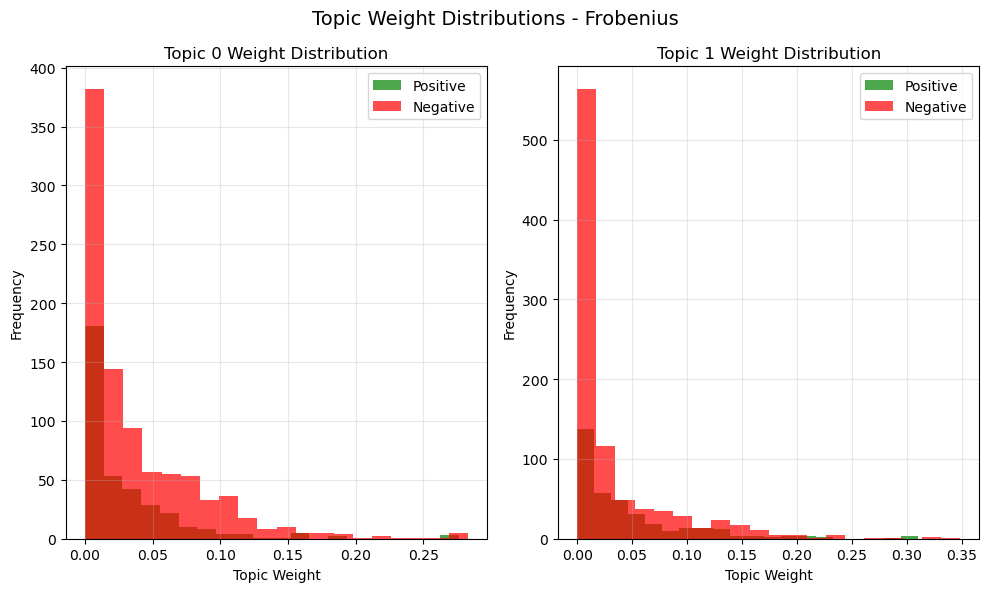


TOPIC EXPLORATION - KL-Divergence

Top 10 words per topic:

Topic 0:
  composition: 0.8817
  method: 0.5830
  food: 0.5744
  containing: 0.4085
  agent: 0.3472
  producing: 0.3105
  beverage: 0.2788
  inhibitor: 0.2778
  extract: 0.2472
  frozen: 0.2267

Topic 1:
  compositions: 0.7402
  methods: 0.5369
  cannabis: 0.4078
  use: 0.3820
  gum: 0.3658
  products: 0.3498
  chewing: 0.3381
  confectionery: 0.3308
  thereof: 0.3137
  cannabinoid: 0.2939

Topic distribution by class:

Negative class:
  Topic 0: 0.0591
  Topic 1: 0.0381

Positive class:
  Topic 0: 0.0416
  Topic 1: 0.0598


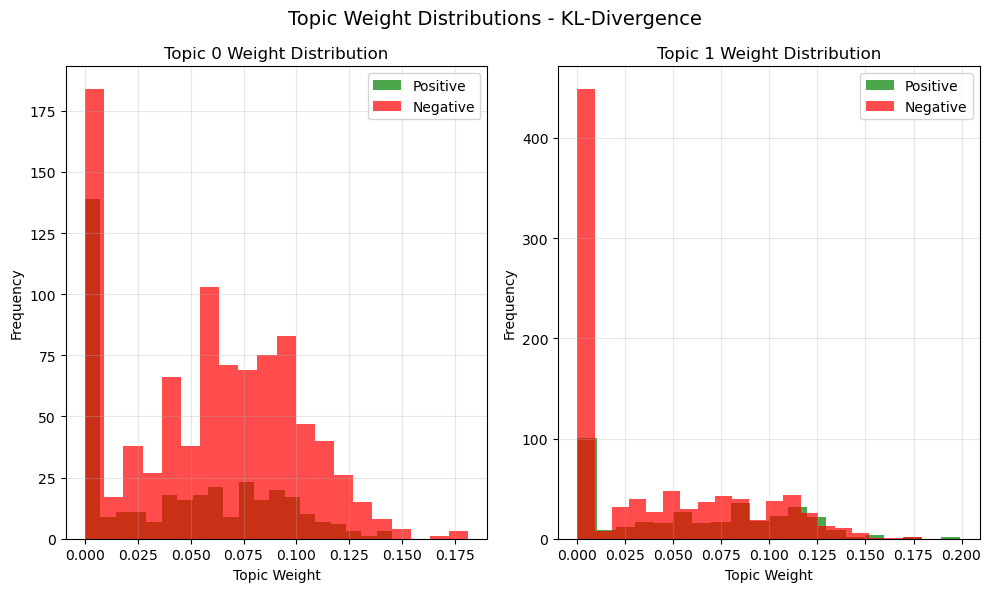

In [13]:
def explore_nmf_topics(nmf_results, n_top_words=10):
    """Explore and visualize NMF topics"""
    if vectorizer is None:
        print("Error: Must run NMF analysis first")
        return
        
    feature_names = vectorizer.get_feature_names_out()
    
    for loss_type, results in nmf_results.items():
        print(f"\n{'='*50}")
        print(f"TOPIC EXPLORATION - {loss_type}")
        print(f"{'='*50}")
        
        H = results['H']  # Topic-word matrix
        W = results['W']  # Document-topic matrix
        n_components = H.shape[0]
        
        # 1. Show top words for each topic
        print(f"\nTop {n_top_words} words per topic:")
        for topic_idx in range(n_components):
            top_words_idx = H[topic_idx].argsort()[-n_top_words:][::-1]
            top_words = [feature_names[i] for i in top_words_idx]
            top_scores = H[topic_idx][top_words_idx]
            
            print(f"\nTopic {topic_idx}:")
            for word, score in zip(top_words, top_scores):
                print(f"  {word}: {score:.4f}")
        
        # 2. Analyze topic distribution by class
        train_size = len(train_df)
        train_W = W[:train_size]
        y_true = train_df['target'].values
        
        print(f"\nTopic distribution by class:")
        for class_label in [0, 1]:
            class_mask = y_true == class_label
            class_name = "Negative" if class_label == 0 else "Positive"
            class_W = train_W[class_mask]
            
            print(f"\n{class_name} class:")
            avg_weights = np.mean(class_W, axis=0)
            for topic_idx, weight in enumerate(avg_weights):
                print(f"  Topic {topic_idx}: {weight:.4f}")
        
        # 3. Visualize topic weights
        plot_topic_analysis(W, y_true, loss_type, train_size)



def plot_topic_analysis(W, y_true, loss_type, train_size):
    """Create visualizations for topic analysis"""
    train_W = W[:train_size]
    n_components = W.shape[1]
    
    # Create subplots
    fig, axes = plt.subplots(1, n_components, figsize=(5*n_components, 6))
    if n_components == 1:
        axes = [axes]
    
    for topic_idx in range(n_components):
        ax = axes[topic_idx]
        
        # Get topic weights for each class
        pos_weights = train_W[y_true == 1, topic_idx]
        neg_weights = train_W[y_true == 0, topic_idx]
        
        # Create histograms
        ax.hist(pos_weights, alpha=0.7, label='Positive', bins=20, color='green')
        ax.hist(neg_weights, alpha=0.7, label='Negative', bins=20, color='red')
        
        ax.set_title(f'Topic {topic_idx} Weight Distribution')
        ax.set_xlabel('Topic Weight')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Topic Weight Distributions - {loss_type}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Explore NMF topics
print("\nNMF Topic Exploration:")
explore_nmf_topics(nmf_results)


Component Comparison:
Comparing n_components for KL-Divergence loss:
--------------------------------------------------
n_components= 2: Accuracy=0.6203, Reconstruction Error=172.2800
n_components= 3: Accuracy=0.6273, Reconstruction Error=168.1677
n_components= 5: Accuracy=0.6562, Reconstruction Error=160.1778
n_components= 8: Accuracy=0.6555, Reconstruction Error=153.3577
n_components=10: Accuracy=0.6531, Reconstruction Error=149.5720


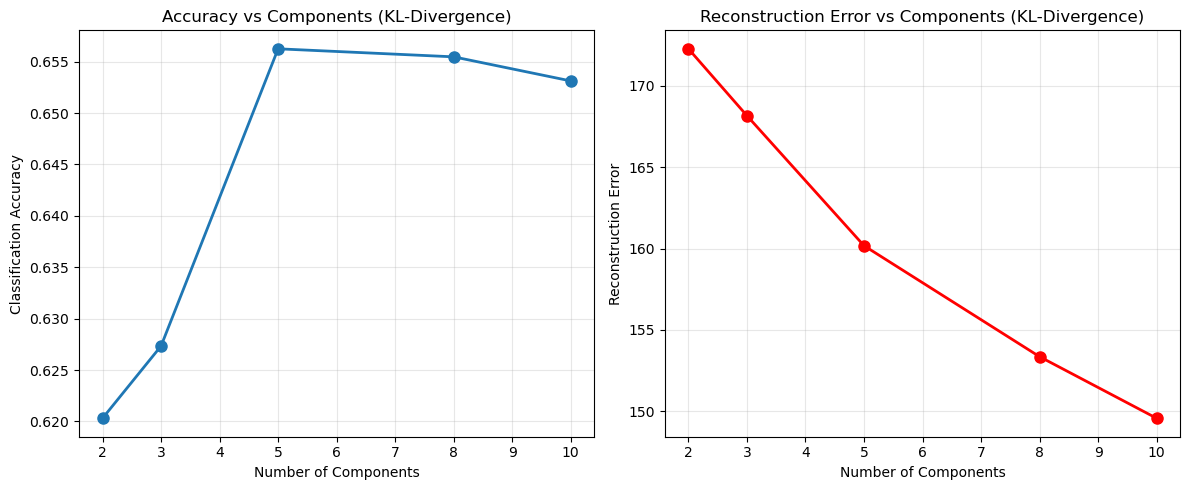

In [14]:
def compare_n_components(component_range=[2, 3, 5, 8, 10], loss_type='KL-Divergence'):
    """Compare NMF performance across different numbers of components"""
    if tfidf_matrix is None:
        create_tfidf_matrix()
        
    results = []
    train_size = len(train_df)
    y_true = train_df['target'].values
    
    print(f"Comparing n_components for {loss_type} loss:")
    print("-" * 50)
    
    for n_comp in component_range:
        # Choose appropriate initialization based on loss type
        if loss_type == 'KL-Divergence':
            nmf = NMF(n_components=n_comp, random_state=42, 
                     init='nndsvda', solver='mu', beta_loss='kullback-leibler', 
                     max_iter=1000)
        else:
            nmf = NMF(n_components=n_comp, random_state=42, 
                     init='nndsvd', max_iter=1000)
        
        W = nmf.fit_transform(tfidf_matrix)
        
        # For binary classification, use the component with highest weight
        if n_comp == 2:
            predictions = np.argmax(W[:train_size], axis=1)
        else:
            # For more components, try simple clustering approaches
            # Option 1: Use first two components
            predictions = np.argmax(W[:train_size, :2], axis=1)
        
        # Find best label mapping
        acc_0 = accuracy_score(y_true, predictions)
        acc_1 = accuracy_score(y_true, 1 - predictions)
        accuracy = max(acc_0, acc_1)
        
        results.append({
            'n_components': n_comp,
            'accuracy': accuracy,
            'reconstruction_error': nmf.reconstruction_err_
        })
        
        print(f"n_components={n_comp:2d}: Accuracy={accuracy:.4f}, "
              f"Reconstruction Error={nmf.reconstruction_err_:.4f}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    n_comps = [r['n_components'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    errors = [r['reconstruction_error'] for r in results]
    
    ax1.plot(n_comps, accuracies, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Classification Accuracy')
    ax1.set_title(f'Accuracy vs Components ({loss_type})')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(n_comps, errors, 'o-', color='red', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Reconstruction Error')
    ax2.set_title(f'Reconstruction Error vs Components ({loss_type})')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Compare different numbers of components
print("\nComponent Comparison:")
component_results = compare_n_components()

#### Increasing Hyperparameter Number of Components increased Accuracy until N=5 and Reduced Reconstruction Error until N=10

As the charts above show, accuracy hit a maximum at N=5, whereas Reconstruction Error continued to improve until N=10.  Probably reconstruction error would continue to get smaller at N>10 until eventually reaching a mininum value.


Logistic Regression Analysis:
Training with  10% of data: Accuracy = 0.8125
Training with  25% of data: Accuracy = 0.8406
Training with  50% of data: Accuracy = 0.8547
Training with  75% of data: Accuracy = 0.8594
Training with 100% of data: Accuracy = 0.8641


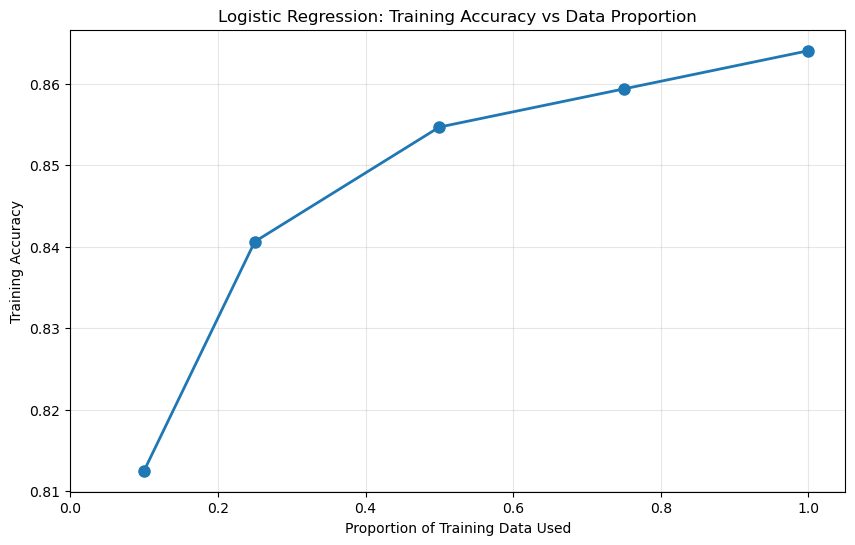

In [16]:
def run_logistic_regression_analysis(proportions=[0.1, 0.25, 0.5, 0.75, 1.0]):
    """Run logistic regression with different training data proportions"""
    if tfidf_matrix is None:
        create_tfidf_matrix()
        
    train_size = len(train_df)
    X_train = tfidf_matrix[:train_size]
    y_train = train_df['target'].values
    
    accuracies = []
    
    for prop in proportions:
        n_samples = int(prop * train_size)
        
        # Use subset of training data
        X_subset = X_train[:n_samples]
        y_subset = y_train[:n_samples]
        
        # Train model
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_subset, y_subset)
        
        # Evaluate on subset
        y_pred = model.predict(X_subset)
        accuracy = accuracy_score(y_subset, y_pred)
        accuracies.append(accuracy)
        
        print(f"Training with {prop*100:3.0f}% of data: Accuracy = {accuracy:.4f}")
        
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(proportions, accuracies, marker='o', linewidth=2, markersize=8)
    plt.xlabel("Proportion of Training Data Used")
    plt.ylabel("Training Accuracy")
    plt.title("Logistic Regression: Training Accuracy vs Data Proportion")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1.05)
    plt.show()
    
print("\nLogistic Regression Analysis:")
run_logistic_regression_analysis()

### Logistic regression had 81% accuracy using 10% of the data.  The other 90% of data increased accruacy to .86%.

For this type of data set, logistic regression can achieve high accuracy without even using most of the training data.

# Conclusion

The true power of the unsupervised model is the ability to construct an arbitrary number of categories, which humans would not have imagined before construction. Even though we know there are five "real" categories, there may be any number of subtopics that exist within the data. A follow up project would be to iterate over the number of categories and try to find spikes in test prediction accuracy. This would correspond to the discovery of true subtopics. 
 
The Logistic Regression ran faster than the unsupervised models because it did not have to factor a large sparse matrix. To maximize accuracy, choose the supervised model. 

I learned a lot about NMF, KL-Divergence, Frobenius, TF-IDF and how to use these techniques in analyzing a patent document dataset.

My thanks to the team that creating this Cannabinoid Edible patent document data set for machine learning.  

### References
FreeCodeCamp on TF-IDF for text processing
https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/

Medium blog post on TF-IDF for text processing
https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424

https://medium.com/betacom/bow-tf-idf-in-python-for-unsupervised-learning-task-88f3b63ccd6d

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

https://www.ml4patents.com/

"Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation" https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

Le Thi Khanh Hien, Nicolas Gillis, "Algorithms for Nonnegative Matrix Factorization with the Kullback-Leibler Divergence,"
https://arxiv.org/abs/2010.01935

Dataset located at: https://github.com/swh/classification-gold-standard

See this article for the background behind the creation of the dataset. Steve Harris, Anthony Trippe, David Challis, and Nigel Swycher, "Construction and evaluation of gold standards for patent classification—A case study on quantum computing", World Patent Information, Vol 61, June, 2020.
https://www.sciencedirect.com/science/article/pii/S0172219019300791

This Jupyter Notebook python code was written using Anaconda Navigator and is located at: https://github.com/tomplunkett/Data-Science/tree/main/Patents%20Unsupervised%20Learning